In [1]:
import numpy as np
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
import functions
from GP import GP
from GP_grad import GP_grad
import time
import imageio

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
# objective = functions.sincos(Noise, Noise_level)
# objective = functions.Shubert(Noise, Noise_level)
objective = functions.Ackley_2(Noise, Noise_level)

f = objective.func
clean_f = lambda x: functions.Ackley_2().func(x)


B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]
print(f( np.array([2, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES']
acquation_function = 'random'

[[-4.  4.]
 [-4.  4.]]
[[5.42213172]]
dim:  2


#### Finding Optimized Hyperparameter $\sigma, \ell$

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


closeness = 1
def close_draw(n_random_draws=4):
    # sample from a small 2d box with center Xc
    Xc = np.asarray(np.random.uniform(lb + closeness, ub - closeness, size=(1, dim)))
    X[0] = Xc
    for i in range(1, n_random_draws):
        X[i] = Xc + closeness*np.random.uniform(-1, 1, Xc.shape)
    return X


def optimize_hyper(lb, ub, sample_size=200):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# find optimized hyper
gp = GP_grad(B, Noise, Noise_level)
(ls, var) = optimize_hyper(lb, ub, sample_size=200)
del gp
(ls, var)

(0.7038042299552781, 508.06743034251235)

#### Grid & Plot

In [6]:
# creating meshgrid to plot over entire range
n_Grid = 100
x1 = np.linspace(lb[0], ub[0], n_Grid)
x2 = np.linspace(lb[1], ub[1], n_Grid)

X1, X2 = np.meshgrid(x1, x2)
Grid = np.vstack((X1.flatten(), X2.flatten())).T
Grid.shape

(10000, 2)

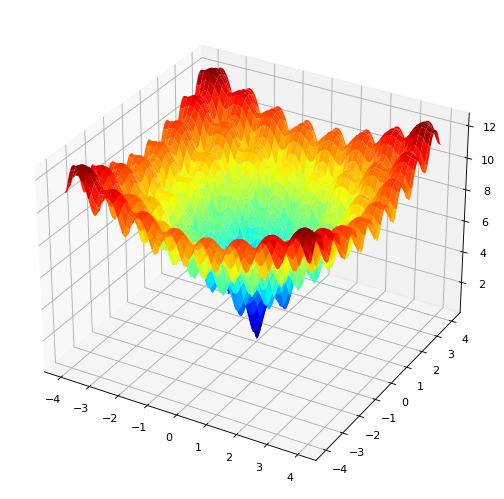

(10000, 1)

In [7]:
# 3d plot of the test function
from numpy import arange
from numpy import meshgrid
from matplotlib import pyplot
from matplotlib.pyplot import figure
# compute targets
results = f(Grid).reshape(X1.shape)
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, results, cmap='jet')
# show the plot
pyplot.show()
f(Grid).shape

In [9]:
# 3d plot of the gradient
# approximate the gradient
from scipy import optimize


# optimize.approx_fprime(x, clean_Ackley_1d, eps)
eps = np.sqrt(np.finfo(float).eps)
approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
approx_grad.shape
g1 = approx_grad[:, 0]
g2 = approx_grad[:, 1]
g1, g2

(array([-0.89865756,  3.00157022,  4.83463907, ..., -4.83463907,
        -3.00156951,  0.89865828]),
 array([-0.89865756, -0.91510785, -0.931777  , ...,  0.93177772,
         0.91510868,  0.89865828]))

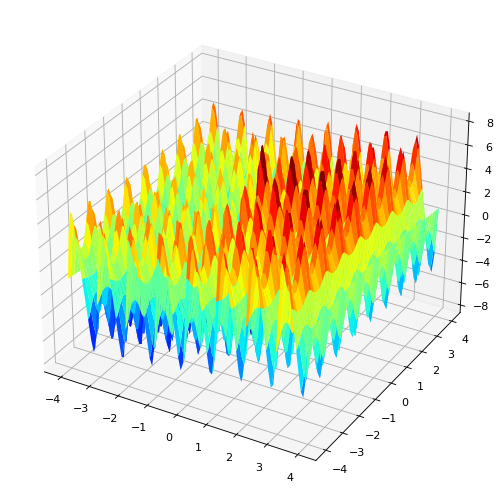

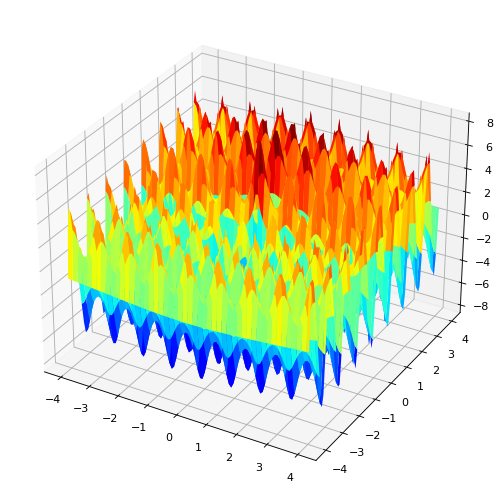

In [10]:
# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g1.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

# create a surface plot with the jet color scheme
figure = pyplot.figure(figsize=(14, 8), dpi=80)
axis = figure.gca(projection='3d')
axis.plot_surface(X1, X2, g2.reshape(X1.shape), cmap='jet')
# show the plot
pyplot.show()

In [11]:
# # test posterior_joint_grad
# XPtest = np.linspace(-5, 5, 2).reshape(-1, dim)
# XQtest = np.linspace(-5, 5, 2).reshape(-1, dim)

# # Xt = np.vstack([XPtest, XQtest])
# MM, VV = gp.posterior_joint_grad(0, 1, XPtest, XQtest)

# gp.set_p(0)
# M1, V1 = gp.posterior_grad(XPtest)

# gp.set_p(1)
# M2, V2 = gp.posterior_grad(XQtest)

# # XPtest, XQtest
# XPtest = np.array([[6.41019595, 7.62193654]])
# XQtest = np.array([[6.41019595, 7.62193654]])
# gp.Kpq(0, 1, XPtest, XQtest)

# gp.posterior_joint_grad(0, 1, XPtest, XQtest)
# full_K = gp.prior_joint_MVN(0, 1, XPtest, XQtest, full=True)
# np.linalg.det(full_K)

## Gradient-based Method

In [125]:
# initial data
init_size = 4
# X = np.asarray(np.random.uniform(lb, ub, size=(init_size, dim)))
X = np.zeros((init_size, dim))
# X = np.asarray(np.random.uniform(lb, ub, size=(init_size, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
X = close_draw(init_size)
X

array([[ 1.68789247, -2.50029641],
       [ 2.42569923, -1.70560776],
       [ 1.19560235, -3.0483697 ],
       [ 1.79882381, -1.83778899]])

In [126]:
gp = GP_grad(B, Noise, Noise_level)
gp.set_hyper(ls, var)

n_iter = 20

gp.set_data(X, f(X))
gp.fit()

# automated gradient descent
lr = 0.001
alpha = 0.5

# w: starting point of gd
w = X[0]

full_query = X
history_restart = [1]
history_w = [w.reshape(-1, dim)]
history_df = [gp.grad_mean(w)]
history_f = [[f(w).item()]]

# w = np.mean(X, axis=0) # center point of init x
gp.grad_mean(w), gp.grad_sample(w), optimize.approx_fprime(w, lambda x: clean_f(x).item(), eps) # via posterior mean
# gp.grad_sample(w) # via sampling from the posterior distribution

(array([ 0.60064675, -1.34027692]),
 array([-24.84670956,   6.42619256]),
 array([-0.42404616, -1.52717948]))

In [127]:
# Nesterov
v = np.array([0, 0])
def nesterov(gp, w, v):
    df = gp.grad_mean(w-0.9*v)
#     df = optimize.approx_fprime(w, clean_Ackley, eps)
    v = 0.9*v + lr*df
    return w - v, v, df
    
# Adam
epsilon = 1e-8
b1 = 0.9
b2 = 0.999
eta = 5e-1
mt = np.array([0, 0])
vt = np.array([0, 0])

In [128]:
# Gradient-Method Loop
from operator import itemgetter
fail_count = 0
hit_boundary = False

for i in range(1, n_iter):
    print(i, end = ', ')
    print('w: ', history_w[-1][-1], end = ', ')
    print('f(w): ', history_f[-1][-1], end = ', ')
    print('df(w): ', history_df[-1][-1], end = '')
    print()
    
    # update w
    if fail_count == 10 or hit_boundary or LA.norm(gp.grad_mean(w)) < 1e-6:
        print('REBOOT! ', end = ', ')
        print('Hit = ', hit_boundary, end = ', ')
        print('Fail = ', fail_count, end = ', ')
        print('Norm = ', LA.norm(gp.grad_mean(w)), end = ', ')
        print('...')

        # random restart with 3 new points
        X = close_draw(init_size)
        w = X[0]
        # reboot optimizer
        v = np.array([0, 0])
        
        # change back to initial setting
        fail_count = 0
        hit_boundary = False 
        full_query = np.vstack([full_query, X])
        restart = True    
        print(w)
        print()
    else:
        restart = False
        # Nesterov
        n_GD = 100
        for j in range(n_GD):
            w, v, df = nesterov(gp, w, v)
        # check boundary hit, if yes, restart
        if not ((lb < w).all() and (ub > w).all()):
            hit_boundary = True
            w = np.clip(w, lb, ub)
        full_query = np.vstack([full_query, w])
        
    # Adam
    # approximate first and second moment
#     gt = gp.grad_mean(w)  
# #     gt = optimize.approx_fprime(w, clean_Ackley, eps)
#     mt = b1 * mt + (1 - b1) * gt
#     vt = b2 * vt + (1 - b2) * np.square(gt)

#     # bias corrected moment estimates
#     mhat = mt / (1 - b1 ** i )
#     vhat = vt / (1 - b2 ** i )

#     # update the params
#     delta_w = -1 * eta * mhat/(np.sqrt(vhat) + epsilon)
# #     w = np.clip(w + delta_w, lb, ub)
#     w = w + delta_w
    
    # Query at w + fitting GP
    gp.add_data(w.reshape(1, -1), f(w))
    gp.fit()
    
    # after Query
    if f(w) < [min(l) for l in history_f][-1]:
        fail_count = 0
    else:
        fail_count += 1
    
    # record
    history_restart.append(restart)
    if restart == False:
        history_f[-1].append(f(w).item())
        np.vstack([history_w[-1], w])
        np.vstack([history_df[-1], gp.grad_mean(w)])
    else:
        history_f.append([f(w).item()])
        history_w.append(w)
        history_df.append(gp.grad_mean(w))

1, w:  [ 1.68789247 -2.50029641], f(w):  9.162646885035954, df(w):  [ 0.60064675 -1.34027692]
2, w:  [ 1.68789247 -2.50029641], f(w):  4.252235912186805, df(w):  [ 0.60064675 -1.34027692]
3, w:  [ 1.68789247 -2.50029641], f(w):  3.276486401947207, df(w):  [ 0.60064675 -1.34027692]
4, w:  [ 1.68789247 -2.50029641], f(w):  7.630223240993734, df(w):  [ 0.60064675 -1.34027692]
5, w:  [ 1.68789247 -2.50029641], f(w):  9.638167581182765, df(w):  [ 0.60064675 -1.34027692]
REBOOT! , Hit =  True, Fail =  2, Norm =  0.7922872115131449, ...
[ 1.64825364 -2.65964696]

6, w:  -2.6596469570061823, f(w):  9.30262607349439, df(w):  -0.14463559363205514
7, w:  -2.6596469570061823, f(w):  12.014597438510606, df(w):  -0.14463559363205514
REBOOT! , Hit =  True, Fail =  2, Norm =  0.2910768794929183, ...
[-2.00949372  1.82972038]

8, w:  1.8297203810628666, f(w):  7.006016663327991, df(w):  0.6951460093249886
9, w:  1.8297203810628666, f(w):  9.404599872195224, df(w):  0.6951460093249886
REBOOT! , Hit =  T

In [130]:
for lw in history_w:
    print(lw)
# history_w

[[-2.23534154 -2.23227153]]
[-2.23534154 -2.23227153]
[-2.23534154 -2.23227153]
[-2.23534154 -2.23227153]
[-2.23534154 -2.23227153]
[-2.23534154 -2.23227153]
[-2.23534154 -2.23227153]


[array([-1.61965272,  0.66511082]), array([-2.2626456 ,  0.58168922]), array([-1.68500127,  2.65055855]), array([-1.07527782,  4.        ])]
[array([-1.61965272,  0.66511082]), array([0.37634458, 1.01821324]), array([1.83990749, 0.06578469]), array([ 3.49993852, -1.01449461]), array([ 4.       , -2.2675908])]
[array([-1.61965272,  0.66511082]), array([-0.45217065, -1.95606253]), array([-1.3100514 , -3.85892044]), array([-1.99122247, -4.        ])]
[array([-1.61965272,  0.66511082]), array([ 1.59216079, -2.6021578 ]), array([ 2.182643, -4.      ])]
[array([-1.61965272,  0.66511082]), array([-0.62272256, -0.3202777 ]), array([-0.87523489, -0.45667226]), array([-0.12246961,  0.01912769])]


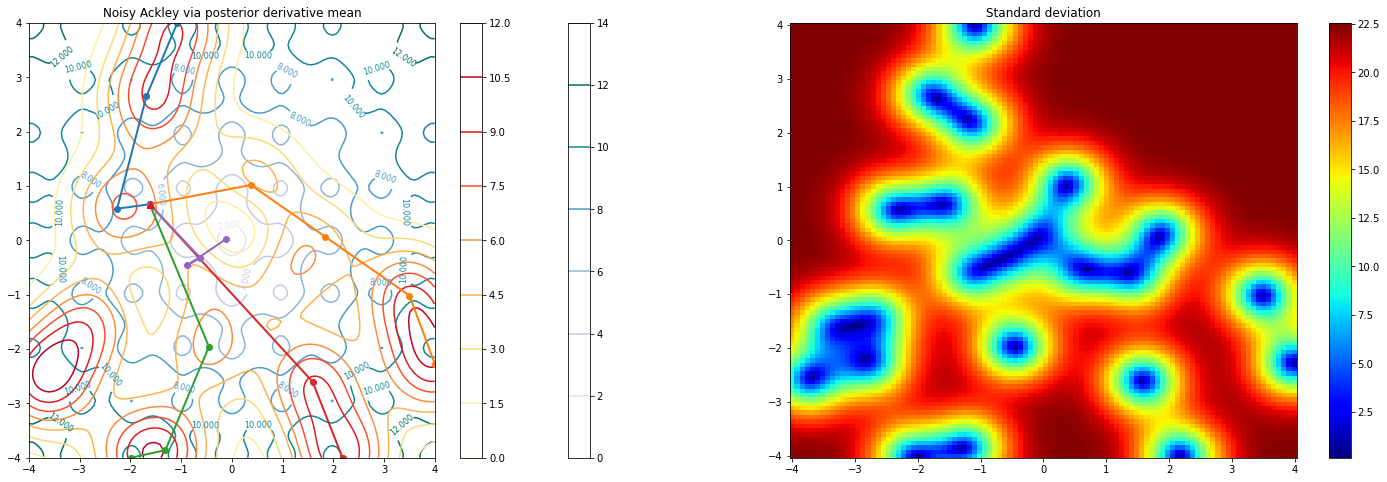

In [59]:
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(20, 12))
x = Grid[:,0]
y = Grid[:,1]

# Posterior
mu, covar = gp.posterior(Grid)
mu = np.squeeze(mu)
s = np.sqrt(np.diag(covar))

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(25, 8))

# plot function
im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
fig.colorbar(im, ax=ax2)

im1 = ax1.contour(X1, X2, clean_f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

pl.clabel(im1, inline=True, fontsize=8)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax1)

for lw in history_w:
    ax1.plot(np.array(lw)[:, 0], np.array(lw)[:, 1], 'o-', linewidth=2)
    ax1.plot(lw[0][0], lw[0][1], "r^", markersize=7, alpha=0.8)

ax1.title.set_text("Noisy Ackley via posterior derivative mean")
ax2.title.set_text("Standard deviation")

# plot derivative
#     p1 = y*np.cos(y)* ( (2*x*np.cos(x)) - np.sin(x) ) / (2* (x*y)**(3/2))
#     p2 = - x*np.sin(x)* ( (2*y*np.sin(y)) + np.cos(y) ) / (2* (x*y)**(3/2))
#     p1 = np.cos(x)*np.cos(y)
#     p2 = -np.sin(x)*np.sin(y)

#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, p1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, p2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.plot(w[0], w[1], "ro", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")
# Saving all the plots in 2D_Plots (need to creat a folder) 

filename = 'Ackley2d_noisy_mean.png'
pl.savefig('2D_Plots/' + filename)
pl.show()

In [ ]:
pl.figure(figsize=(10, 6), dpi=80)
axis = 1
for l in history_f:
    pl.plot(np.arange(axis, axis+len(l)), l, "c-^")
    pl.plot(axis, l[0], "r^")
    axis += len(l)

pl.plot()

# Af = np.array(history_f)
# Ar = np.array(history_restart)
# Af.shape, Ar.shape
# pl.plot(Ar.nonzero()[0], Af[Ar.nonzero()], "m^")

pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)
print(history_f[1])

In [ ]:
# only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

## Thompson Sampling

In [ ]:
### Thompson Sampling
import os
gp.clear()
gp.set_hyper(ls, var)
gp.set_data(X, f(X))
gp.fit()

n_iter = 110
history = []

w = X[0].reshape(-1, 1)

# save to
filenames = []
for i in range(1,  n_iter):
    filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
    filenames.append(filename)

folder = '2D_Plots/Ackley/'
if not os.path.exists(folder):
    os.makedirs(folder)

In [ ]:
for i in range(1,  n_iter):
    # posterior of GP given gp.X, gp.y
    mu, covar = gp.posterior(Grid)
    mu = np.squeeze(mu)
#     s = np.sqrt(np.diag(covar))
    
    # posterior of GP derivative given gp.X, gp.y
    # partial x1
#     gp.set_p(0)
#     mu_grad_1, covar_grad_1 = gp.posterior_grad(Grid)
#     mu_grad_1 = np.squeeze(mu_grad_1)
#     s_grad_1 = np.sqrt(np.diag(covar_grad_1))

#     # partial x2
#     gp.set_p(1)
#     mu_grad_2, covar_grad_2 = gp.posterior_grad(Grid)
#     mu_grad_2 = np.squeeze(mu_grad_2)
#     s_grad_2 = np.sqrt(np.diag(covar_grad_2))

    L = np.linalg.cholesky(covar + 1e-6*np.eye(n_Grid**dim)) # LL^T = Sigma (posterior covariance)
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n_Grid**dim, 1)))
    arg_min = np.argmin(f_post)
    w = Grid[arg_min]
    
    
#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    
    print('w: ', w)
    history.append( f(w) )
    gp.add_data(w.reshape(1, dim), f(w))
    gp.fit()

In [ ]:
pl.figure(figsize=(10, 6), dpi=80)
pl.plot(np.squeeze(history), "-^")
pl.title("function values as the algorithm runs")
pl.xlabel("n_iter")
pl.ylabel("loss function")
pl.grid(True)

In [ ]:
# # Creates the .gif from the saved plots for the 2D_Plots dir.
# frames = []
# for filename in filenames:
#     frames.append(imageio.imread(folder + filename))
# exportname = 'Ackley_TS.gif'

# kargs = { 'duration': 0.5 }
# imageio.mimsave(exportname, frames, 'GIF', **kargs)